In [ ]:
!pip install arviz==0.11.0
!pip install pymc3==3.11.1
!pip install PyAstronomy
#!pip install --upgrade --force-reinstall matplotlib


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
#import scipy
import pandas as pd

import pymc3 as pm
import theano as tt
import arviz 
pd.options.display.max_rows = 4000
 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

print(f"Running on PyMC3 v{pm.__version__}")

Mounted at /content/drive
Running on PyMC3 v3.11.1


In [ ]:
def mean_fn(t, B, A, c, h, f, m, k):
  '''this is the mean function defined by Barnes with a metalicity dependance bashed onto the end
  parameters are free to vary'''

  return A * (t)**c  * (B-h)**f * (m+1)**k



def log_err(vals, val, err_lo):
  '''
  Not used currently
  '''
  return np.mean(np.log(vals)) - np.log(np.mean(vals)- err_lo) ## this works 



def lin_err(val, sig_hi, sig_lo):
  return (sig_hi +sig_lo)/2
  


def Rossby_number(modlogg, Teff, Prot):
  '''
  Determines the Rossby number from the surface gravity, effective temperature and period if rotation.

  Not used currently
  '''
  g = np.power(10, modlogg) / 100
  tau_o = 200
  g_o = 274
  Teff_o = 5778
  convective_overturn_timescale =  tau_o * g_o/g* np.power(Teff/Teff_o, 1/2)  # this in in seconds 

  return Prot / convective_overturn_timescale

f = np.vectorize(Rossby_number)


46.12643678160919
[-0.99 -0.92 -0.54 -0.44 -0.42 -0.4  -0.37 -0.31 -0.29 -0.28 -0.26 -0.24
 -0.23 -0.23 -0.23 -0.21 -0.2  -0.2  -0.19 -0.18 -0.18 -0.16 -0.15 -0.15
 -0.14 -0.13 -0.13 -0.13 -0.12 -0.12 -0.12 -0.11 -0.11 -0.11 -0.1  -0.09
 -0.09 -0.08 -0.08 -0.08 -0.08 -0.07 -0.07 -0.07 -0.06 -0.05 -0.05 -0.04
 -0.04 -0.04 -0.04 -0.03 -0.02 -0.02 -0.01  0.    0.    0.01  0.01  0.01
  0.01  0.02  0.02  0.05  0.05  0.05  0.06  0.07  0.08  0.08  0.09  0.09
  0.09  0.1   0.1   0.1   0.11  0.11  0.12  0.13  0.15  0.16  0.17  0.17
  0.19  0.21  0.22  0.25  0.26  0.28  0.29  0.3   0.34  0.36]
Using:  87
From:  94


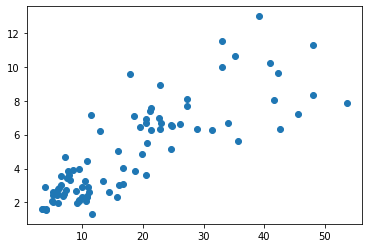

In [ ]:
##### OPTIONS #####
#data1 16th points = 91 total

data = pd.read_csv('/content/drive/My Drive/data/real_data.csv', header=0)

flag = np.array(data['flag'])
Teff = np.array(data['Teff'])
Teff_err = np.array(data['eTeff'])

Age = np.array(data['age']) # convert to Megayrs
Age_err_lo = np.array(data['loage'])
Age_err_hi = np.array(data['upage'])

Prot = np.array(data['P'])
Prot_err_lo = np.array(data['l_P'])
Prot_err_hi = np.array(data['u_P'])

KIC = np.array(data['KIC'])

Mass  = np.array(data['modmass'])
Mass_err_lo = np.array(data['lomodmass'])
Mass_err_hi = np.array(data['upmodmass'])
mod_log_g = np.array(data['modlogg'])

source = np.array(data['source']) # source paper

hr_class = np.array(data['hrclass']) # hierarchical class

metal = np.array(data['feh'])
metal_err = np.array(data['efeh'])

b = pyasl.BallesterosBV_T()
data_points = Prot.shape[0]




Age_err = np.array([lin_err(Age[i], Age_err_lo[i], Age_err_hi[i]) for i in range(data_points)])
Prot_err = np.array([lin_err(Prot[i], Prot_err_lo[i], Prot_err_hi[i]) for i in range(data_points)])

#sel_good = np.where((Age > 0.5)& (Prot_err < 40) & (Age != 2.6) & (flag != 3) &(flag!=2) & (metal != -0.44)) # select stars that arent too young and have 'sensible' error
bad = [3427720, 10644253,6603624, 8760414, 8938364, 9965715, 11081729]

sel = np.where((np.isin(KIC,bad)==False) & (Mass > 0))
print(np.mean(sel))
plt.scatter(Prot[sel], Age[sel], label='data')

print(np.sort(metal))

# limits the range of stars to 79 out of 94


#print(np.sort(np.delete(Age, sel_bad)))



Teff = Teff[sel]
Teff_err = Teff_err[sel]
Age = Age[sel]
KIC = KIC[sel]
Age_err_lo = Age_err_lo[sel]
Age_err_hi = Age_err_hi[sel]
Age_err = Age_err[sel]
metal = metal[sel]
metal_err = metal_err[sel]
source = source[sel]
Mass = Mass[sel]
hr_class = hr_class[sel]
Mass_err_hi = Mass_err_hi[sel]
Mass_err_lo = Mass_err_lo[sel]

Prot = Prot[sel]
Prot_err_lo = Prot_err_lo[sel]
Prot_err_hi = Prot_err_hi[sel]

Prot_err = Prot_err[sel]
mod_log_g = mod_log_g[sel]
BV =  b.t2bv(np.array(Teff))

BV_err = Teff_err/Teff * BV

data_points = Prot.shape[0]

print('Using: ',data_points)
print('From: ',data.shape[0])



#Ro = f(mod_log_g, Teff, Prot)
# 3, 26 gone in latter


There is no obvious direct relation between metalicity and rotation, but I suspect including it will benefit the model. 
Therefore, I will be adding onto the mean function and the GP fitting, as per the other values, I will jsut be using a simple power law dependance. 
Looking at work previosuly done by Louis Amard, we can expect a negeatve power law of small magnitude. I will set the prior on this value to be uniform between -0.01 and 0.
I will also add in a 3rd kernel to account for this variables behaviour in the GP. as done previosuly the priors on the lengthscale and amplitude will be determined by eye by looking at the data
this has worked well so far.

As seen in the plot above, just adding the metalicity power law dependance makes a minimal change to the apparent fit before the GP. However, when applied to the GP it may make an improvement. 

Worst case: No improvement

Most likely case: minimal improvement

Best case: significant improvement. 


"*We find that metal-poor stars are rotating faster than theirsolar metallicity counterparts of the same mass and age buthave a higher stellar Rossby number. In particular, stars with ahigher mass than the Sun are very sensitive to metallicitybecause of their proximity to the Kraft break where the Rossbynumber is changing very quickly with the depth of theconvective zone, and thus with the chemical composition or themass of the star*" - from (The Impact of Metallicity on the Evolution of the Rotation and Magnetic Activity of Sun-like StarsLouis Amarda)

I think the next stage here will be to add in some mass dependance into the GP and see what this does. Up till now, Ive been under the impression that including a mass dependance will be detrimental as mass and B-V as proxies for one-another. Never-the-less, at this stage of the project I have already been able to make accuate predictions, if the mass addition is detrimental, I can just remove it B).    - mass is still bad/ 

(60,)


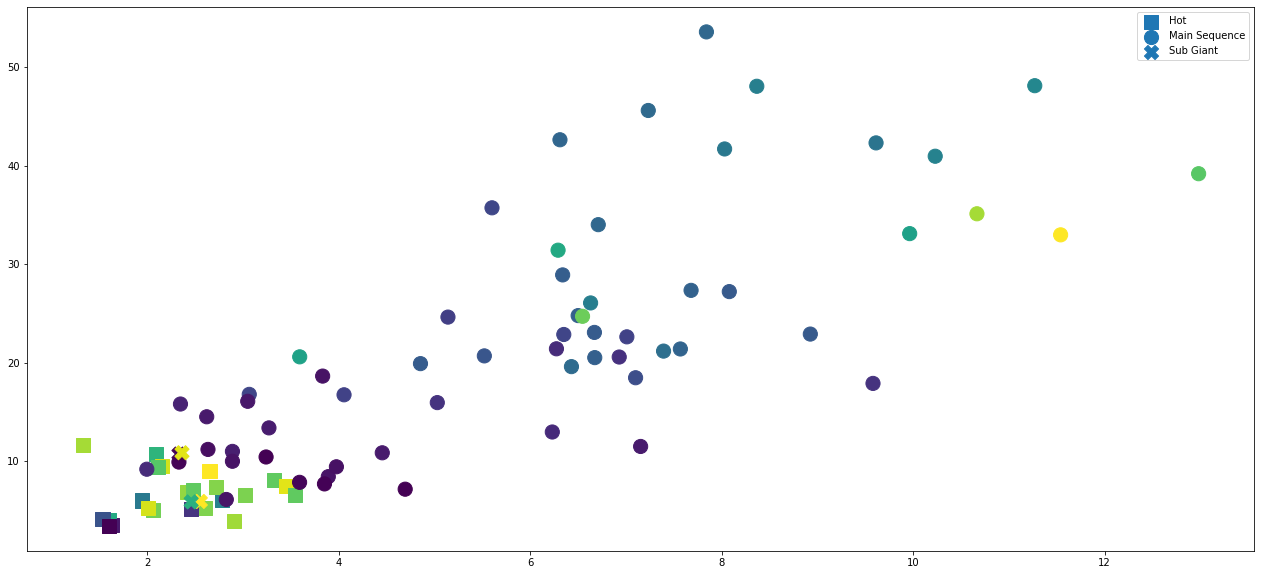

In [ ]:
fig = plt.figure(figsize=(22, 10))
H = np.where(hr_class=='H')
plt.scatter(Age[H], Prot[H], c=BV[H], cmap=cm.viridis, marker='s', label='Hot', s=200)

MS = np.where(hr_class=='MS')
plt.scatter(Age[MS], Prot[MS], c = BV[MS], cmap=cm.viridis, marker='o', label='Main Sequence', s=200)
print(Age[MS].shape)

SG = np.where(hr_class=='SG')
plt.scatter(Age[SG], Prot[SG], c = BV[SG], cmap=cm.viridis, marker='X', label='Sub Giant', s=200)
plt.legend()

In [ ]:
#plt.scatter(Ro, Age)

print('All of our stars fall below the critical Rossby number 2.16 (defined by Van Saders)')




All of our stars fall below the critical Rossby number 2.16 (defined by Van Saders)


Just by looking at these two plots of Mass against period and 1/(B-V) and period, we can see that there is a clearly a similar depednace between these two variables (Note: here the B-V is  being determined from the temperature). Therefore, I will not try and fit a power law to it, instead just smash it into the GP.

To get an idea for the hyperpriors:

Lengtscale, look a the span of Mass values, 1.6-0.7  = 0.9 

Amplitude, look at the biggest difference in preiod for similar mass values, 30ish (this is likely a big over estimate but that will become apparent in the fit.)

https://iopscience.iop.org/article/10.1088/0004-637X/695/1/679/pdf
In this article a form is given to determine P from Bv and age that is of a slightly sifferent form to what I am currently using.
$P(t, B-V) = t^{0.52} g(B-V -h)^f$ <br>
where $g=0.77, h=0.4, f = 0.6$. I will now construct another GP using this as the mean function and see how it goes.

Im gonna sort of bash the BV dependance onto the end of my current mass, age mean function and see how it goes B). The new mean function will look like $P(t,m,(B-V)) = At^cm^d((B-V)-h)^f$. Where I a taking d from the previous GP, here A is going to be allowed to vary and the starting value will be $A^{\star}g$, where $A^{\star}$ is the A from before.  

This has resulted in considerably better results.


In [ ]:
#### book ####


h = 0.4 
f = 0.601 
c = 0.5189 
A = 0.7725 * np.sqrt(1000) 

# values defined by Barnes 


X = np.array([Age, BV, metal]).T 


with pm.Model() as model:


    '''
    # Error defined in Barnes model
    c_ = pm.Uniform('c_', c-0.007, c+0.007)
    f_ = pm.Uniform('f_', f-0.024, f+0.024)
    A_ = pm.Uniform('A_', A*0.85, A*1.15)
    '''

    # Fixed priors

    '''
    c_ = c
    f_ = f
    A_ = A
    k_ = 0
    '''

    # Normalal distributed priors
    c_ = pm.Normal('c_', c, c*0.2)
    f_ = pm.Normal('f_', f, f*0.2)
    A_ = pm.Normal('A_', A, A*0.20)
    k_ = pm.Normal('k_', 0, 0.1)
    #k_ = pm.Uniform('k_', -0.01, 0)


  # Latent Variables
    Age_true = pm.Uniform('Age_true', 0, 14, shape=data_points)
    Age_obs = pm.Normal("Age_obs", Age_true, np.abs(Age_err), observed=X[:,0])

    BV_true = pm.Lognormal("BV_true", 1, 1, shape=data_points)
    BV_obs = pm.Normal("BV_obs", BV_true, np.abs(BV_err), observed=X[:,1])

    metal_true = pm.Uniform('metal_true', -1, 1, shape=data_points)
    metl_obs = pm.Normal('metal_obs', metal_true, np.abs(metal_err), observed=X[:,2])

  # mean function
    mean = mean_fn(Age_true, BV_true, A_,c_,h,f_, metal_true, k_)
    resid = Prot - mean

  # Hyper parameters and Kernels

    l1 = pm.Normal('l1', mu=13, sigma=2)  # 20   #age
    l2 = pm.Lognormal("l2", np.log(0.15), 0.1)   # B-V
    l3 = pm.Normal("l3", 1.4, 0.2)               # metallicity

    sf = pm.Normal('sf', 7, 3)

    K1 = pm.gp.cov.ExpQuad(3, l1) #* sf1**2
    K2 = pm.gp.cov.ExpQuad(3, l2)# * sf2**2
    K3 = pm.gp.cov.ExpQuad(3, l3) #* sf3**2
    K = K1 * K2 * K3* sf**2

    #X = tt.tensor.stack([Age_true, BV_true, metal_true]).T
    #X = np.array([Age_true, BV_true, metal_true]).T 

    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X , y=resid, noise=np.abs(Prot_err))


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sf, l3, l2, l1, metal_true, BV_true, Age_true, k_, A_, f_, c_]


Sampling 4 chains for 4_000 tune and 3_000 draw iterations (16_000 + 12_000 draws total) took 15234 seconds.


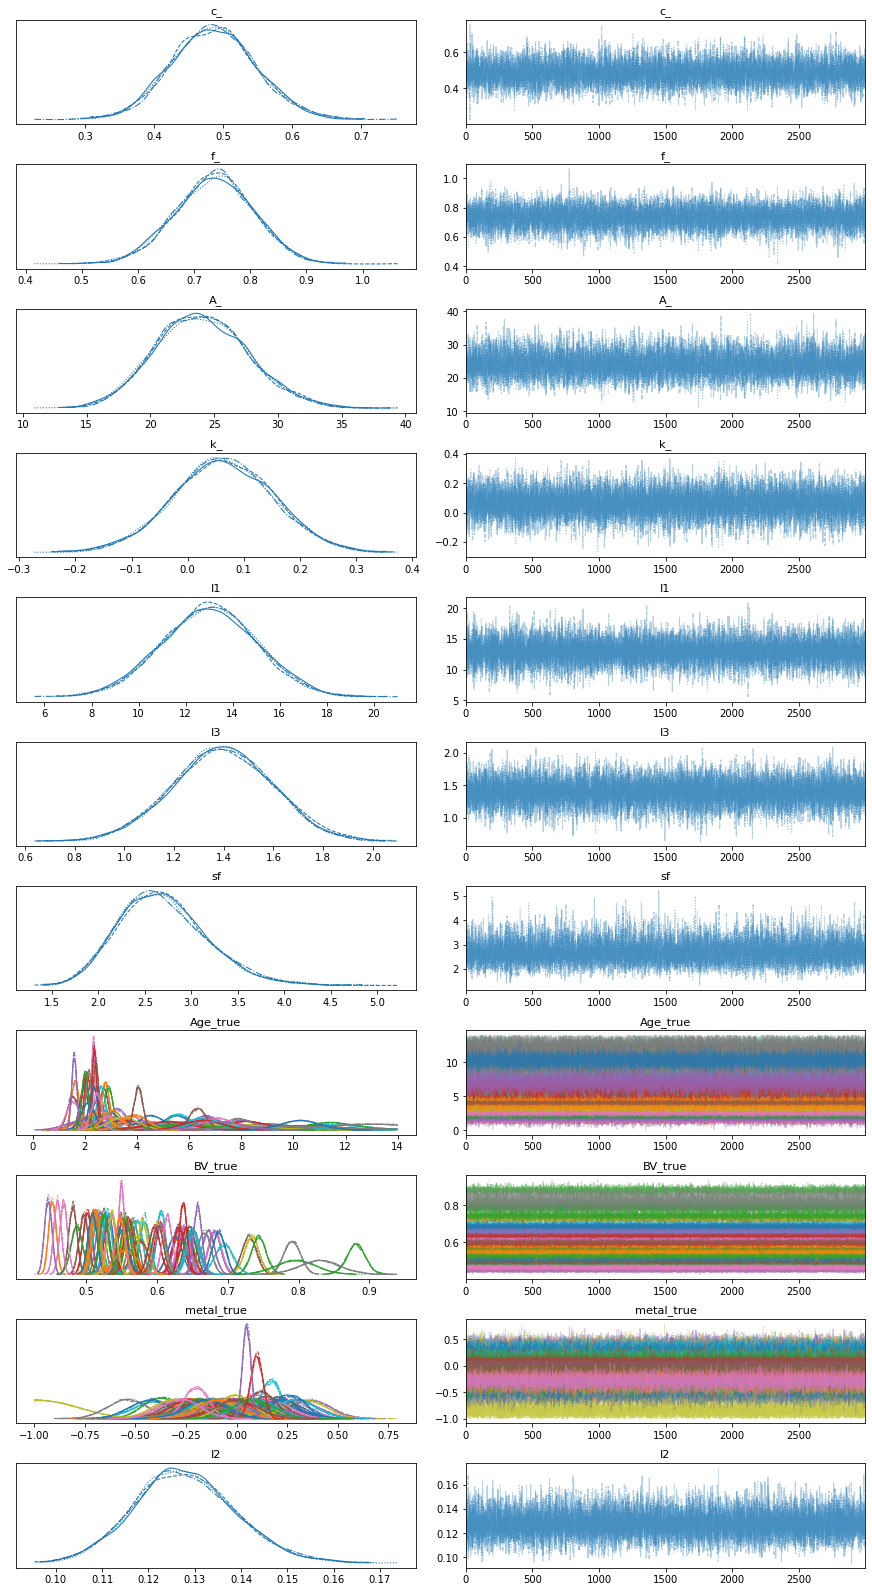

In [ ]:

with model:
  trace = pm.sample(3000, tune=4000, cores=4, target_accept=0.99)
  arviz.plot_trace(trace)
  

In [ ]:
with model:
  print(arviz.summary(trace))


#print(trace.remove_values('f_pred'))
#lst = trace.varnames
#lst.append('f_pred')
#vars = np.asarray(lst)

#with model:
#  f_pred = gp.conditional('f_pred', X, pred_noise=False) # predict function
#  pred_samples = pm.sample_posterior_predictive(trace, var_names=vars, samples=2500)

## DO I NEED THIS???

                  mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
c_               0.486  0.061   0.374  ...   11114.0    9170.0    1.0
f_               0.736  0.070   0.605  ...   12418.0    9722.0    1.0
A_              24.032  3.628  17.168  ...    9874.0    9334.0    1.0
k_               0.063  0.089  -0.104  ...   17157.0    9580.0    1.0
l1              13.011  2.005   9.252  ...   34238.0    8159.0    1.0
l3               1.394  0.200   1.020  ...   24052.0    8528.0    1.0
sf               2.700  0.483   1.818  ...   13115.0    9387.0    1.0
Age_true[0]      2.973  0.414   2.216  ...   25059.0    8295.0    1.0
Age_true[1]      1.630  0.143   1.366  ...   24254.0    8137.0    1.0
Age_true[2]      3.317  0.723   1.949  ...   18579.0    6849.0    1.0
Age_true[3]      2.104  0.128   1.866  ...   26803.0    7907.0    1.0
Age_true[4]      6.705  0.579   5.629  ...   23846.0    8240.0    1.0
Age_true[5]      2.731  0.169   2.413  ...   22359.0    8542.0    1.0
Age_true[6]      9.0

In [ ]:

new_err = np.mean([ trace.get_values('Age_true')[:,i].std()/  trace.get_values('Age_true')[:,i].mean() for i in range(data_points)])
old_err =np.mean(np.abs(Age_err/Age))


print('Initianl error: ', old_err*100, '%')
print('New error: ', new_err*100,'%')
print("Difference in error = {}%  :)".format(round((new_err-old_err)*100,5)))


Initianl error:  15.191604813958467 %
New error:  13.539973023985109 %
Difference in error = -1.65163%  :)


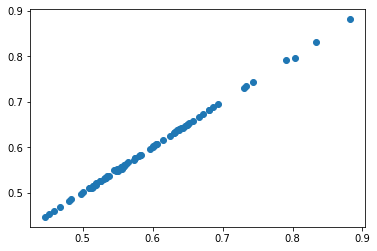

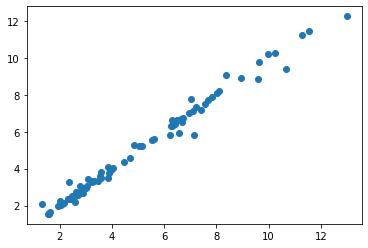

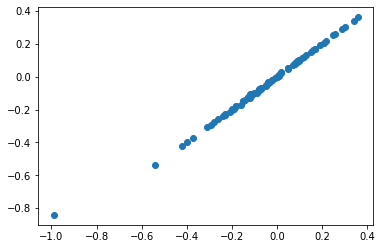

In [ ]:

Age_new = np.mean(trace.get_values('Age_true'), axis=0)
BV_new = np.mean(trace.get_values('BV_true'), axis=0)
metal_new = np.mean(trace.get_values('metal_true'), axis=0)

plt.scatter(BV, BV_new)
plt.show()
plt.scatter(Age, Age_new)
plt.show()
plt.scatter(metal, metal_new)
plt.show()

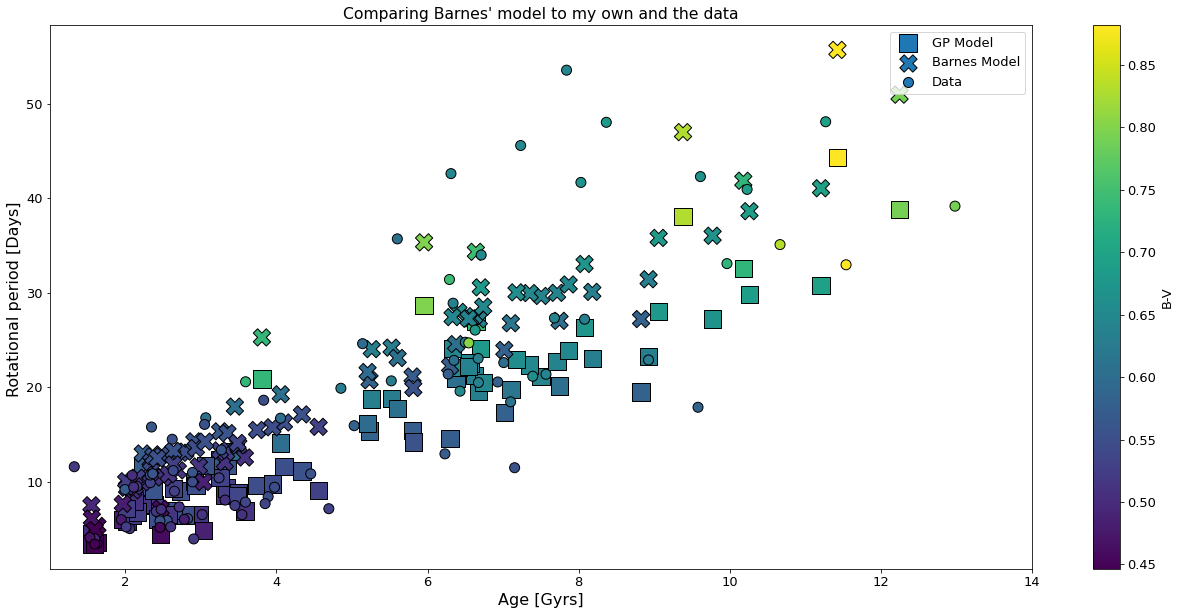

Mean absolute differnece between data and Barnes:  5.399250063702276
40.63929124940014 %
33.14216303497439 %

Mean absolute differnece between data and my model  3.984696572898828
18.32573731803358 %
-6.806322002606843 %


In [ ]:
fig = plt.figure(figsize=(22, 10))
ax = fig.gca()


A = np.mean(trace['A_']) 
c = np.mean(trace['c_'])
h = h
f = np.mean(trace['f_'])
k = 1*np.mean(trace['k_'])

X = np.array([Age_new, BV_new, metal_new]).T
#Xo = np.array([Age, BV, metal]).T

Xo = X

#### testing with metalicity to see if it still consistently under predicts... is this worth doing? 


fit, var = gp.predict(X, point=trace[-1], diag=True)
std = np.sqrt(var) # std deviation determined from gp fitting

mean = mean_fn(X[:,0], X[:,1], A, c ,h,f, X[:,2], k) # Barnes model with GP fitted parameters
mu = fit + mean # adding the GP fit to the model

barnes = mean_fn(Xo[:,0], Xo[:,1], 0.7725*np.sqrt(1000), 0.5189, 0.4, 0.601, metal, 0) 


plt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 's', cmap = cm.viridis, label='GP Model', edgecolors='k')
plt.scatter(Xo[:,0], barnes, s=300, c=Xo[:,1], marker = 'X', cmap = cm.viridis, label='Barnes Model', edgecolors='k')
plt.scatter(Age, Prot, c=BV, cmap=cm.viridis, s=100, edgecolors='k', label='Data')

plt.xlabel('Age [Gyrs]', fontsize=16)
plt.ylabel('Rotational period [Days] ', fontsize=16)
plt.colorbar(label='B-V')

plt.legend()

#scatter(Age[54], Prot[54], c='yellow', s=1000, alpha=0.2)

plt.savefig('col_Ba.png')
#files.download('col_Ba.png')
plt.xlim((1,14))
plt.title("Comparing Barnes' model to my own and the data")
plt.show()


print('Mean absolute differnece between data and Barnes: ', np.mean(np.abs(Prot - mean_fn(X[:,0], X[:,1], 0.7725*np.sqrt(1000), 0.5189, 0.4, 0.601, metal, 0))))
print(np.mean(np.abs(((barnes-Prot)/Prot)*100)), '%')
print(np.mean((((barnes-Prot)/Prot)*100)), '%\n')


print('Mean absolute differnece between data and my model ',np.mean(np.abs(Prot - mu)))
print(np.mean(np.abs(((mu-Prot)/Prot)*100)), '%')
print(np.mean((((mu-Prot)/Prot)*100)), '%')




Here I have shown a comparison between my fitted GP model [Squares] (Barnes as a base, with free fitting paramters and the addition of metallicity), and Barnes model [X], with the true data [O].

For younger stars $1.5\text{Gyrs} \rightarrow 4 \text{Gyrs} $, Barnes seems to consistently over predict period - in relation to the true data.

In the $6\text{Gyrs} \rightarrow 9 \text{Gyrs} $ range, both models considerably under predict for the data some of the slower rotating data points. WHY?

My initial thinking is that the source variable [L or K] is having a large impact on the measured rotation, where K source stars are rotating far slower than their L source counterpart. 

- Look into what L and K represent
- Try and add something to the GP? 

- L and K just represent the source of the data, i.e. what paper it was taken from. 

Beyond $9\text{Gyrs}$ Both models perform okay



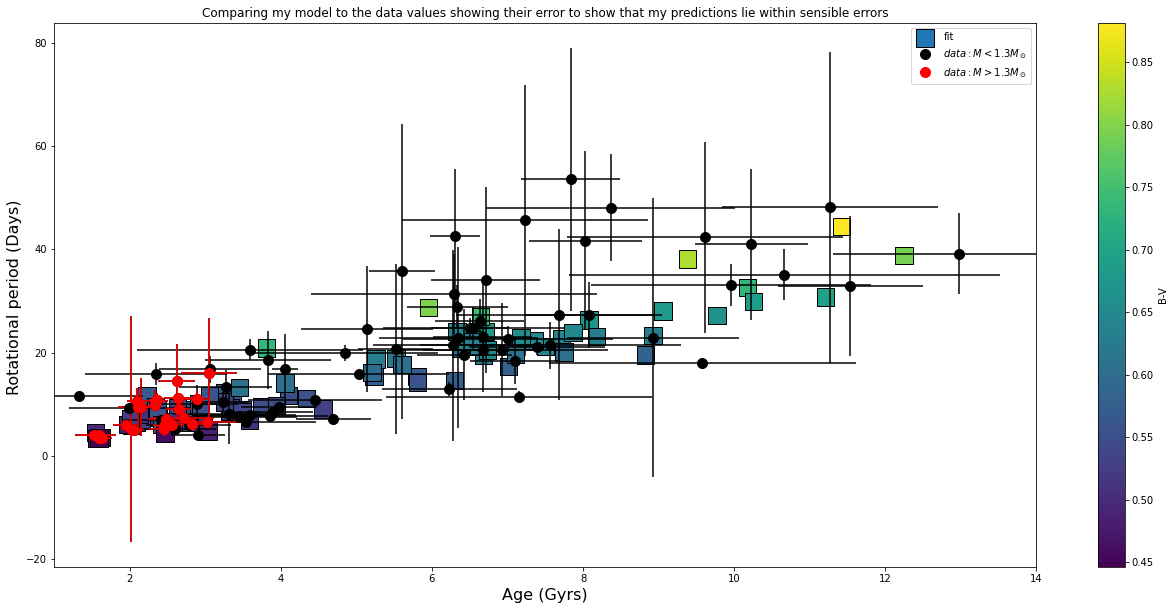

In [ ]:
fig = plt.figure(figsize=(22, 10))
sel = np.where(Mass > 1.3)
plt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 's', cmap = cm.viridis, label='fit', edgecolors='k')

plt.errorbar(Age, Prot, c=BV, xerr=Age_err, yerr=Prot_err, label=r'$data: M < 1.3M_\odot$', fmt='ok', markersize=10)
plt.errorbar(Age[sel], Prot[sel], c=BV[sel], xerr=Age_err[sel], yerr=Prot_err[sel], label=r'$data: M > 1.3M_\odot$', fmt='or', markersize=10)


plt.xlabel('Age (Gyrs)', fontsize=16)
plt.ylabel('Rotational period (Days) ', fontsize=16)
plt.legend()
plt.savefig('col_Ba.png')
plt.xlim((1,14))
plt.title("Comparing my model to the data values showing their error to show that my predictions lie within sensible errors")
plt.colorbar(label='B-V')
plt.show()



Just specifically remove the young bad boys - this should do the trick. In this method there will be no restriction for a given mass. I.e. will train on stars of all mass

Here is a plot of my model vs the data, I have highlighted the high mass $M > 1.3M_\odot$. There is not a noticable difference between the red and black points, this suggests that [**FOR THIS DATA SET**], the Kraft break has no noticable impact.




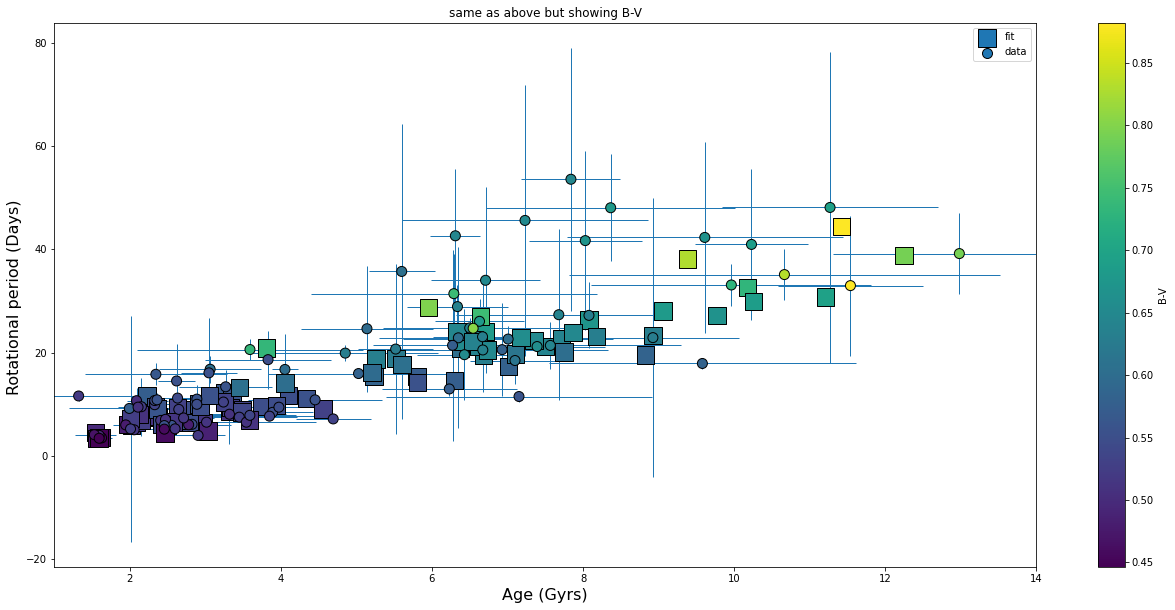

Mean absolute differnece between data and Barnes:  5.399250063702276
Mean absolute differnece between data and my model  3.984696572898828


In [ ]:
fig = plt.figure(figsize=(22, 10))
ax = fig.gca()




plt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 's', cmap = cm.viridis, label='fit', edgecolors='k')
plt.scatter(Age, Prot, c=BV, s=100, cmap = cm.viridis ,label='data', edgecolors='k')

error_kwargs = {"lw":1, "zorder":0}
plt.errorbar(Age, Prot, xerr=Age_err, yerr=Prot_err, fmt='o', marker=None, **error_kwargs,)

plt.legend()

plt.xlabel('Age (Gyrs)', fontsize=16)
plt.ylabel('Rotational period (Days) ', fontsize=16)
plt.colorbar(label='B-V')
plt.savefig('col_Ba.png')
#files.download('col_Ba.png')
plt.xlim((1,14))
plt.title('same as above but showing B-V')
plt.show()

print('Mean absolute differnece between data and Barnes: ', np.mean(np.abs(Prot - mean_fn(X[:,0], X[:,1], 0.7725*np.sqrt(1000), 0.5189, 0.4, 0.601, metal, 0))))
print('Mean absolute differnece between data and my model ',np.mean(np.abs(Prot - mu)))


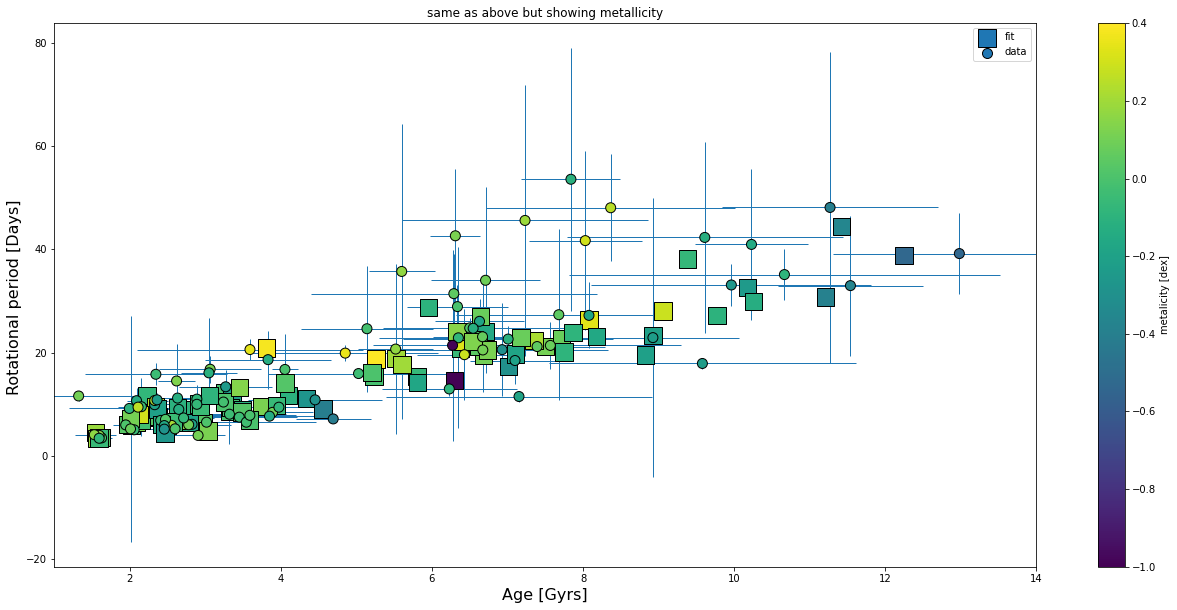

Mean absolute differnece between data and Barnes:  5.399250063702276
Mean absolute differnece between data and my model  3.984696572898828


In [ ]:
fig = plt.figure(figsize=(22, 10))
ax = fig.gca()




plt.scatter(X[:,0], mu, s=300, c=metal, marker = 's', cmap = cm.viridis, label='fit', edgecolors='k')
plt.scatter(Age, Prot, c=metal, s=100, cmap = cm.viridis ,label='data', edgecolors='k')

error_kwargs = {"lw":1, "zorder":0}
plt.errorbar(Age, Prot, xerr=Age_err, yerr=Prot_err, fmt='o', marker=None, **error_kwargs,)

plt.legend()

plt.xlabel('Age [Gyrs]', fontsize=16)
plt.ylabel('Rotational period [Days] ', fontsize=16)
plt.colorbar(label='metalicity [dex]')
plt.clim(-1, 0.4)
plt.savefig('col_Ba.png')
#files.download('col_Ba.png')
plt.xlim((1,14))
plt.title('same as above but showing metallicity')
plt.show()

print('Mean absolute differnece between data and Barnes: ', np.mean(np.abs(Prot - mean_fn(X[:,0], X[:,1], 0.7725*np.sqrt(1000), 0.5189, 0.4, 0.601, metal, 0))))
print('Mean absolute differnece between data and my model ',np.mean(np.abs(Prot - mu)))


This plot shows the data( with its given error and its given B-V) compared to my model predictions. 

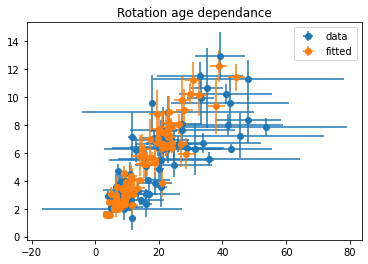

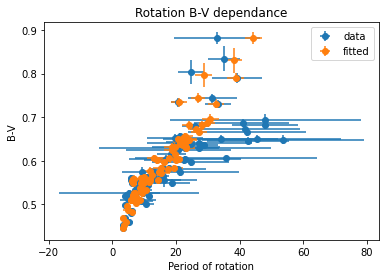

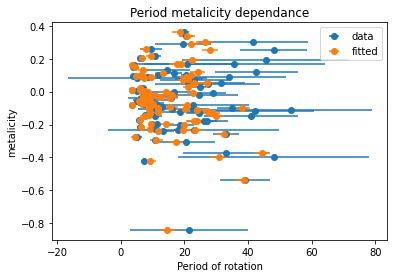

In [ ]:
age_fit_err = [trace.get_values('Age_true')[:,i].std() for i in range(trace.get_values('Age_true').shape[1])]
bv_fit_err = [trace.get_values('BV_true')[:,i].std() for i in range(trace.get_values('BV_true').shape[1])]

# determing the error for each value by looking at the std deviation of the latent parameters 

plt.errorbar(Prot, Age, yerr=Age_err, xerr=Prot_err, fmt='o', label='data')
plt.errorbar(mu, X[:,0], xerr=std, yerr=age_fit_err, fmt='o', label='fitted')
plt.legend()
plt.title("Rotation age dependance")

plt.show()


plt.errorbar(Prot, BV, yerr=BV_err, xerr=Prot_err, fmt='o', label='data')
plt.errorbar(mu, X[:,1], xerr=std, yerr=bv_fit_err, fmt='o', label='fitted')
plt.legend()
plt.xlabel('Period of rotation')
plt.ylabel('B-V')
plt.title('Rotation B-V dependance')
plt.show()



plt.errorbar(Prot, X[:,2], xerr=Prot_err, fmt='o', label='data')
plt.errorbar(mu, metal_new, xerr=std, fmt='o', label='fitted')
plt.legend()
plt.title("Period metalicity dependance")
plt.xlabel('Period of rotation')
plt.ylabel('metalicity')
plt.show()


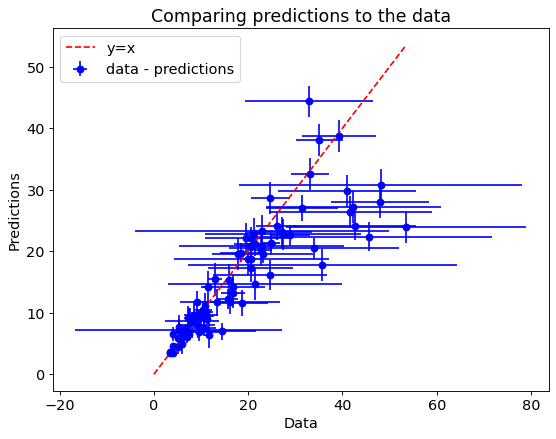

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

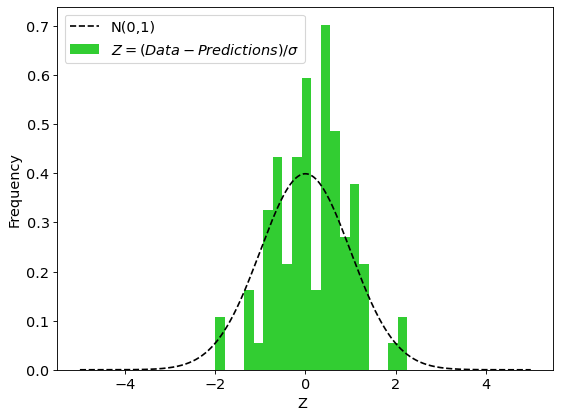

0.17047228707504197
0.8128886993632392


In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot([0, np.max(Prot)], [0, np.max(Prot)], linestyle='--', label='y=x', color='r')
plt.errorbar(Prot, mu, yerr=std, xerr=Prot_err, fmt='o', label=r'data - predictions', color='b', alpha=1)
#plt.scatter([Prot[k[-1]]], [mu[k[-1]]], marker='s', color='y', s=300)

#plt.fill_between(Prot, mu - std, mu + std, alpha=0.3, label=r'$\sigma$',interpolate=True, color='blue')
#plt.fill_between(Prot, mu - 2*std, mu + 2*std, alpha=0.2, label=r'$2\sigma$', interpolate=True, color='b')

plt.xlabel('Data')
plt.ylabel('Predictions')
plt.savefig("R_Ba.png")
#files.download("R_Ba.png") 
plt.legend()
plt.xlabel('Data')
plt.ylabel('Predictions')
plt.title('Comparing predictions to the data')
plt.show()


Z = (Prot - mu)/np.sqrt(std**2 + Prot_err**2)
x = np.linspace(-5,5, 1000)
norm = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 


plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(Z, density=True, label=r'$Z=(Data-Predictions)/\sigma$', color='limegreen', bins=20)
plt.plot(x,norm, label='N(0,1)', color='k', linestyle='--')
plt.xlabel('Z ')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("H_Ba.png")
files.download("H_Ba.png") 


#plt.hist(np.random.normal(0,1, size=Z.shape[0]), density=True)
plt.show()
print(Z.mean())
print(np.std(Z))



There is a consistent outlier [metallicity = -0.44] I cant see any particular reason in the data as to why this point should obviosuly be so bad. May just remove it :) 

In [ ]:
#print(np.mean(Z))
# this is where I am analysing the outliers in the data. Looking at the n left most elements and m right most elements. 
# I can then find the index of these points then look at then highlight them in the plots and/or analyse the other parameters of the star(s) in question

left = 2
right = -1
#print(np.std(Z))
k = np.argsort(Z)
#print(Z[k])
print('These are the bad ones.')
print('rot',Prot[k[:left]], Prot[k[right:]])

print('Z',Z[k[:left]], Z[k[right:]])
print('age',Age[k[:left]], Age[k[right:]])
print('B-V',BV[k[:left]], BV[k[right:]])
print('Rotation error', Prot_err[k[:left]], Prot_err[k[right:]])
print('mass', Mass[k[:left]], Mass[k[right:]])
print('mtealicity',metal[k[:left]], metal[k[right:]])
print()
print('mu', mu[k[:left]], mu[k[right:]])
print('Prot', Prot[k[:left]], Prot[k[right:]])
print('std', std[k[:left]], std[k[right:]])
print('Prot error', Prot_err[k[:left]], Prot_err[k[right:]])
print()
print('KIC', KIC[k[:left]], KIC[k[right:]])
print()
'''
I dont know if this is true 

have found that stars above the kraft break 1.3 do not follow the patterns we are expecting, so we are going to remove stars above. 
Consistent with kfraft break where we get shallowe convective zones, torques dynamos etc.
agreeing wiht eh metalcity paper, have found that lower metalicty stars spin faster. 


compare with all stars, outliars 3 high mass 1 very metal poor. Kill x most massive stats, if the new run has more massive outliars kill y more. Would be best to go as high
as we can. If we can disprove the Kraft Break, its gonna be a continuum. If our model can account for these high mass stars, can speculate validty of Kraft break
'''

print(k[-1])


These are the bad ones.
rot [3.97442928 5.06509836] [11.61135921]
Z [-1.99751486 -1.87389937] [2.25711695]
age [2.9046 2.0582] [1.3236]
B-V [0.51876267 0.51289009] [0.51944364]
Rotation error [0.49973618 0.09896664] [0.93546604]
mass [1.298  1.5279] [1.1783]
mtealicity [ 0.1  -0.05] [0.1]

mu [6.51535257 5.88730183] [6.43203421]
Prot [3.97442928 5.06509836] [11.61135921]
std [1.16976717 0.42745909] [2.09532483]
Prot error [0.49973618 0.09896664] [0.93546604]

KIC [7206837 6508366] [9139151]

54


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

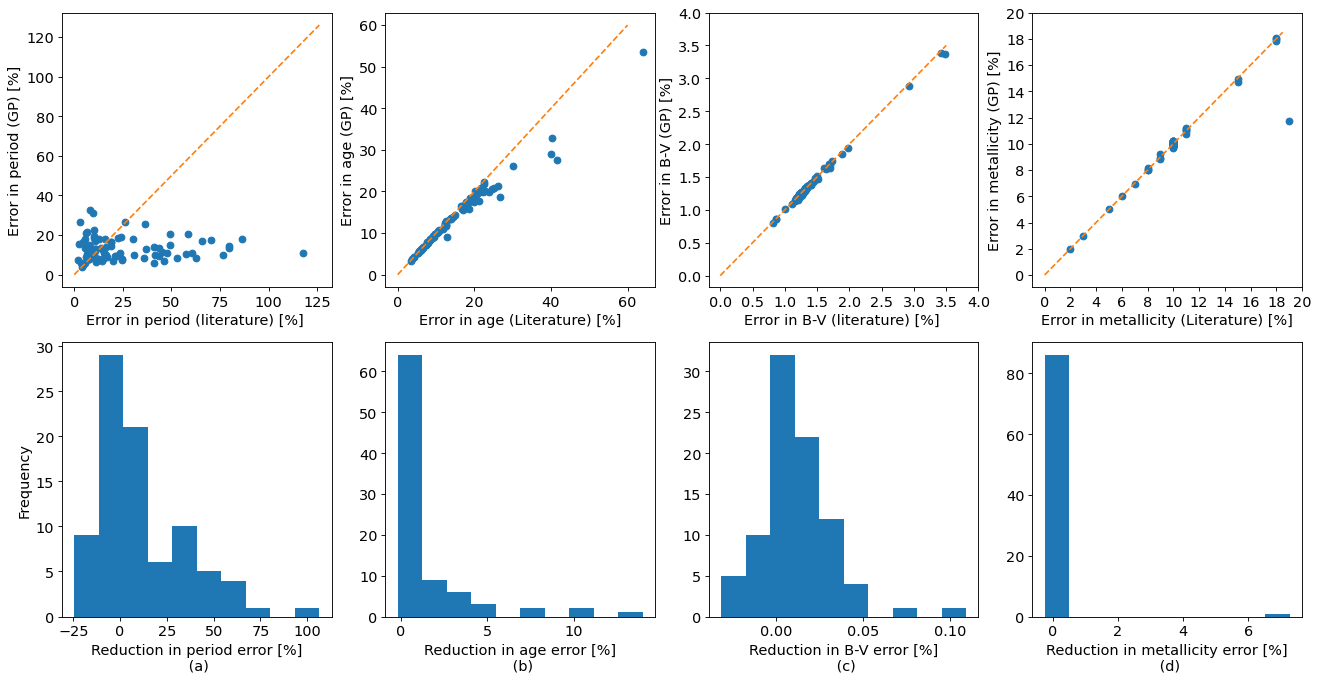

In [ ]:
plt.rcParams.update({'font.size': 13})

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
k = np.argsort(Prot_err/Prot)
plt.subplot(2, 4, 5)
plt.xlabel('Reduction in period error [%]\n (a)')
plt.ylabel('Frequency')
plt.hist((Prot_err/Prot*100 - std/mu*100)[k][:-1])
plt.subplot(2, 4, 1)
plt.plot((Prot_err/Prot*100)[k][:-1], (std/mu*100)[k][:-1],'o')
plt.plot([0,126], [0,126], linestyle='--')
plt.xlabel('Error in period (literature) [%] ')
plt.ylabel('Error in period (GP) [%]')
#plt.show()


# Fix B-V for sveral valuea and plot age vs roation for Barnes and GP. Should see that for Young stars, Barnes and GP agree fairly well as Barnes callibrated on young stars. 
# On Older Barnes will be bad. GP has more flexibility. Should wee GP predicticint faster than Barnes.

# Histogram of the differences between old uncertaintiy and new uncertainity(latent variables SD)
new_err = np.array([ trace.get_values('Age_true')[:,i].std()for i in range(data_points)])
old_err = Age_err
plt.subplot(2, 4, 6)
plt.hist(old_err/Age*100 - new_err/Age*100)
plt.xlabel('Reduction in age error [%]\n (b)')
#plt.ylabel('Frequency')
#plt.show()
plt.subplot(2, 4,2)
plt.plot(old_err/Age*100, new_err/Age*100,'o')
plt.plot([0,60], [0,60], linestyle='--')
plt.xlabel('Error in age (Literature) [%]')
plt.ylabel('Error in age (GP) [%]')
plt.savefig('err_diff_Ba.png')
#files.download('err_diff_Ba.png')
# give this a section 
#plt.show()
#print(np.mean(new_err/Age*100))
#print(np.mean(old_err/Age*100))


#print(np.max(old_err/Age*100- new_err/Age*100 ))


#print(np.mean((std/mu*100)[k][:-1]))
#print(np.mean((Prot_err/Prot*100)[k][:-1]))
#print(np.max((Prot_err[k][:-1]/Prot[k][:-1]*100- std[k][:-1]/mu[k][:-1]*100) ))
#print(np.max(Prot_err/Prot*100))



#plt.figure(num=None, figsize=(7.5, 3.5), dpi=80, facecolor='w', edgecolor='k')
# Histogram of the differences between old uncertaintiy and new uncertainity(latent variables SD)
new_err = np.array([ trace.get_values('BV_true')[:,i].std()for i in range(data_points)])
old_err = BV_err
plt.subplot(2, 4, 7)
plt.hist(old_err/BV*100 - new_err/BV*100)
plt.xlabel('Reduction in B-V error [%]\n (c)')
#plt.ylabel('Frequency')
plt.subplot(2, 4,3)
plt.plot(old_err/BV*100, new_err/BV*100,'o')
plt.plot([0,3.5], [0,3.5], linestyle='--')
plt.xlabel('Error in B-V (literature) [%] ')
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
plt.yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
plt.ylabel('Error in B-V (GP) [%]')



# Histogram of the differences between old uncertaintiy and new uncertainity(latent variables SD)
new_err = np.array([ trace.get_values('metal_true')[:,i].std()for i in range(data_points)])
old_err = metal_err
plt.subplot(2, 4, 8)
plt.hist(old_err*100 - new_err*100)
plt.xlabel('Reduction in metallicity error [%]\n (d)')
#plt.ylabel('Frequency')
#plt.show()
plt.subplot(2, 4,4)
plt.plot(old_err*100, new_err*100,'o')
plt.plot([0,18.5], [0,18.5], linestyle='--')
plt.xlabel('Error in metallicity (Literature) [%]')
plt.ylabel('Error in metallicity (GP) [%]')

#plt.xlim((0,25))
#plt.ylim((0,25))
plt.xticks([0,2,4,6,8,10,12,14,16,18,20])
plt.yticks([0,2,4,6,8,10,12,14,16,18,20])
# give this a section 

plt.savefig('err_diff.png')
files.download('err_diff.png')
plt.show()


In [ ]:
print(np.mean(BV_err/BV*100))
print(np.mean(np.array([ trace.get_values('BV_true')[:,i].std()for i in range(data_points)])/BV*100))

1.3778675222534842
1.3668500163124526


In [ ]:
diff = Prot_err - std
print(np.argmax(diff))
print(Prot[6])
print(mu[6])

max_vals = diff.argsort()[-3:][::-1]
print(max_vals)


9
48.04084382
28.042670599160694
[ 9 49 17]


In [ ]:

new_err = np.mean([ trace.get_values('Age_true')[:,i].std()/  trace.get_values('Age_true')[:,i].mean() for i in range(data_points)])
old_err =np.mean(np.abs(Age_err/Age))






print('Initianl error: ', old_err*100, '%')
print('New error: ', new_err*100,'%')
print("Difference in error = {}%  :)".format(round((new_err-old_err)*100,5)))


'''
new_err = np.array([ trace.get_values('Age_true')[:,i].std()for i in range(data_points)])
old_err = Age_err

print(np.mean(new_err - old_err)*100)
'''
# average difference between the two?? 

Initianl error:  15.191604813958467 %
New error:  13.539973023985109 %
Difference in error = -1.65163%  :)


"\nnew_err = np.array([ trace.get_values('Age_true')[:,i].std()for i in range(data_points)])\nold_err = Age_err\n\nprint(np.mean(new_err - old_err)*100)\n"

In [ ]:

new_err = np.mean(std/mu)
old_err =np.mean(np.abs(Prot_err/Prot))


print('Initianl error: ', old_err*100, '%')
print('New error: ', new_err*100,'%')
print("Difference in error = {}%  :)".format(round((new_err-old_err)*100,5)))


Initianl error:  29.896118622528395 %
New error:  13.3518763328758 %
Difference in error = -16.54424%  :)


These two plots are evidence that this model does fit the data very well. We can use the parameters and hyper parameters gathered here for future GP implementations on true data. 

Second fast component t the gp when we dont have B-V

[]
[]
[]
[]
[]


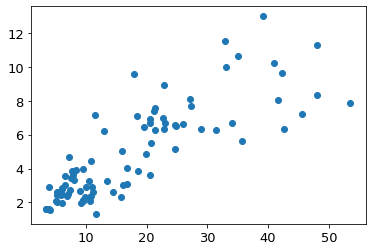

In [ ]:
sel = np.where((Age>7) & (Prot < 4))
print(Prot[sel])
print(KIC[sel])


sel = np.where((Prot > 30) &(Age < 4))
print(Prot[sel])
print(Age[sel])
print(KIC[sel])

bad = [3427720, 10644253,6603624, 8760414, 8938364]

xy, x_ind, y_ind = np.intersect1d(bad, KIC, return_indices=True)

sel = np.where(Age > 0) 

sel = np.delete(sel, y_ind)
plt.scatter(Prot[sel], Age[sel], label='data')

0.06283352327466178


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.06283352327466178
 Differnece between mine and Lachaume metallicity dependance


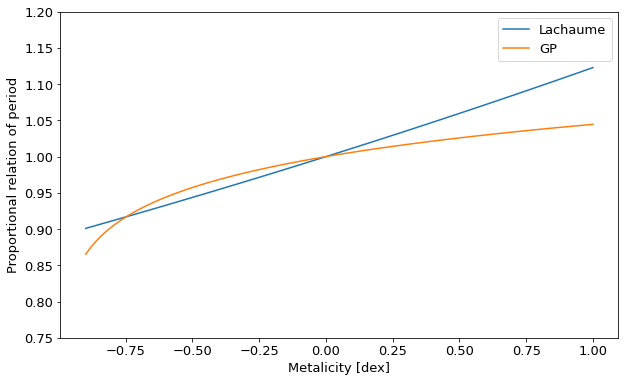

In [ ]:
fig = plt.figure(figsize=(10, 6))
x = np.linspace(-0.9,1,100)
k = np.mean(trace['k_'])
print(k)
plt.plot(x , np.exp(0.11587*x), label='Lachaume')
plt.plot(x, (x+1)**k, label='GP')
plt.ylim((0.75,1.2))
plt.xlabel('Metalicity [dex]')
plt.ylabel('Proportional relation of period')

plt.legend()
plt.savefig('Lach.png')
files.download('Lach.png')
print(k)
print(' Differnece between mine and Lachaume metallicity dependance')

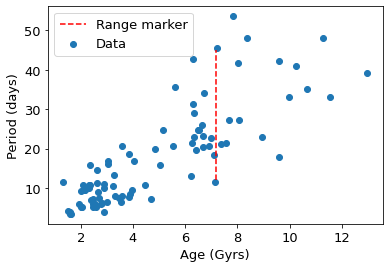

In [ ]:
plt.scatter(Age, Prot, label='Data')
plt.xlabel('Age (Gyrs)')  
plt.ylabel('Period (days)')
plt.plot([7.2,7.2], [12,45], 'r--', label='Range marker')
plt.legend()
plt.savefig('sigma.png')
#files.download('sigma.png')